We will train a LSTM network

all the midis are here:

https://github.com/sebamacchia/MIDIs/tree/master/classics/satie



In [1]:
# dependencies
import numpy as np
import pandas as pd 

# Listing current data on our folder.
import os
print(os.listdir("."))

['.config', 'sample_data']


#Clone github with MIDI files

In [2]:
!git clone https://github.com/sebamacchia/MIDIs.git

#git@github.com:sebamacchia/MIDIs.git

Cloning into 'MIDIs'...
remote: Enumerating objects: 59866, done.
remote: Total 59866 (delta 0), reused 0 (delta 0), pack-reused 59866
Receiving objects: 100% (59866/59866), 532.87 MiB | 25.25 MiB/s, done.
Resolving deltas: 100% (595/595), done.
Checking out files: 100% (60260/60260), done.


So we have in the file folder all the MIDI files

Let's analyze one of the songs, the best known:
Gymnopedie number one.

For that we will use the Music21 library.


In [3]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

file_path = "/content/MIDIs/deepsatie/allthemidis"


def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi((file_path+'/'+ "gymnopedie_1dery.mid"), True)
base_midi

<music21.stream.Score 0x7f5d24875b00>

## we start by listing the instruments


In [4]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("Lista de instrumentos:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

Lista de instrumentos:
Piano
Piano


it has two piano tracks

#What about the score?

In [0]:
from IPython.core.display import display, HTML, Javascript
import json, random
def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)
    
def showMusicXML(xml):
    DIV_ID = "OSMD-div-"+str(random.randint(0,1000000))
    print("DIV_ID", DIV_ID)
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    
    print('xml length:', len(xml))

    script = """
    console.log("loadOSMD()");
    function loadOSMD() { 
        return new Promise(function(resolve, reject){

            if (window.opensheetmusicdisplay) {
                console.log("already loaded")
                return resolve(window.opensheetmusicdisplay)
            }
            console.log("loading osmd for the first time")
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.3.1/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                console.log("loaded OSMD for the first time",opensheetmusicdisplay)
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        console.log("loaded OSMD",OSMD)
        var div_id = "{{DIV_ID}}";
            console.log(div_id)
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id);
        openSheetMusicDisplay
            .load({{data}})
            .then(
              function() {
                console.log("rendering data")
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('{{DIV_ID}}',DIV_ID).replace('{{data}}',json.dumps(xml))
    display(Javascript(script))
    return DIV_ID

In [0]:
showScore(base_midi)

DIV_ID OSMD-div-367435


xml length: 148740


<IPython.core.display.Javascript object>

And the piano roll?

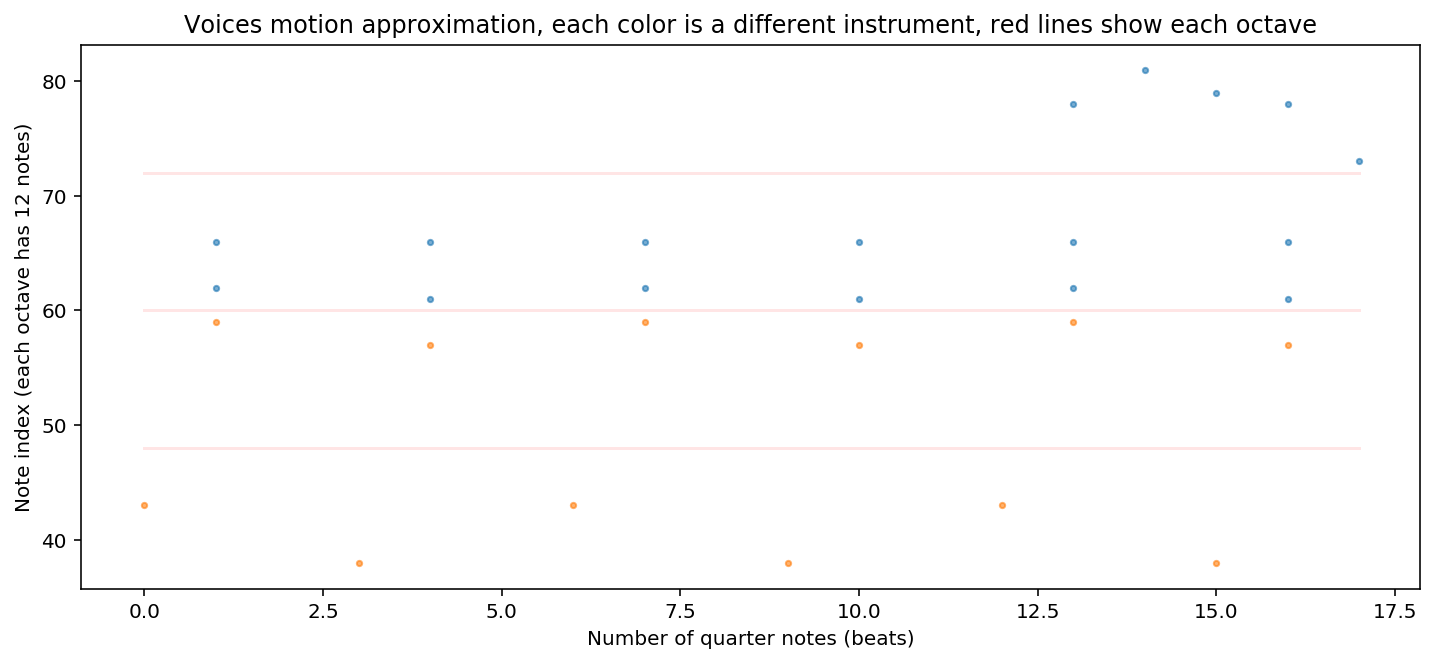

In [0]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

#Now we are going to make a histogram of the pitchs


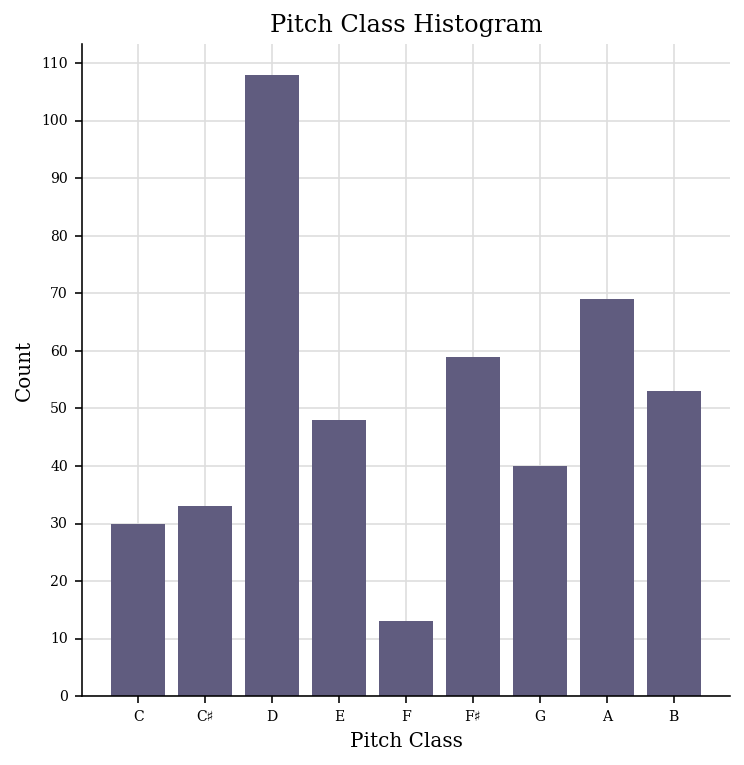

In [0]:
base_midi.plot('histogram', 'pitchClass', 'count')

![Circulo de quintas](https://miro.medium.com/max/2100/1*ihEohPybHu0ourZkFHba-Q.png)

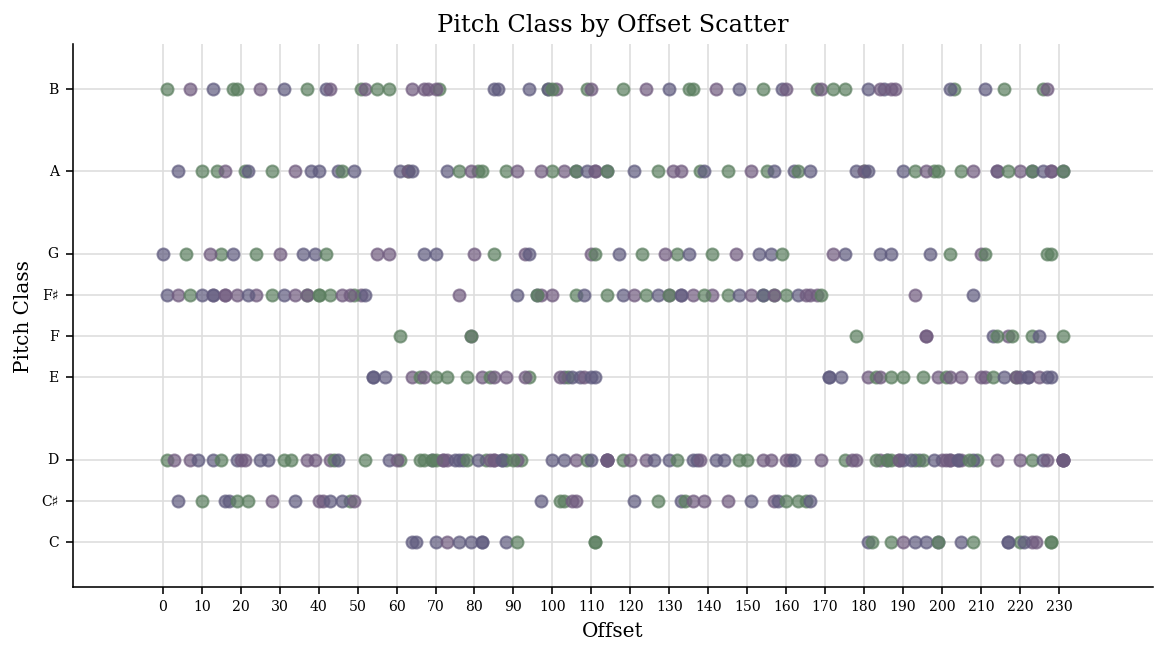

In [0]:
base_midi.plot('scatter', 'offset', 'pitchClass')


#Some musical parameters

In [0]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 3/4
Expected music key: D major
Music key confidence: 0.8453507944403724
Other music key alternatives:
G major
b minor
a minor
d minor
e minor
A major


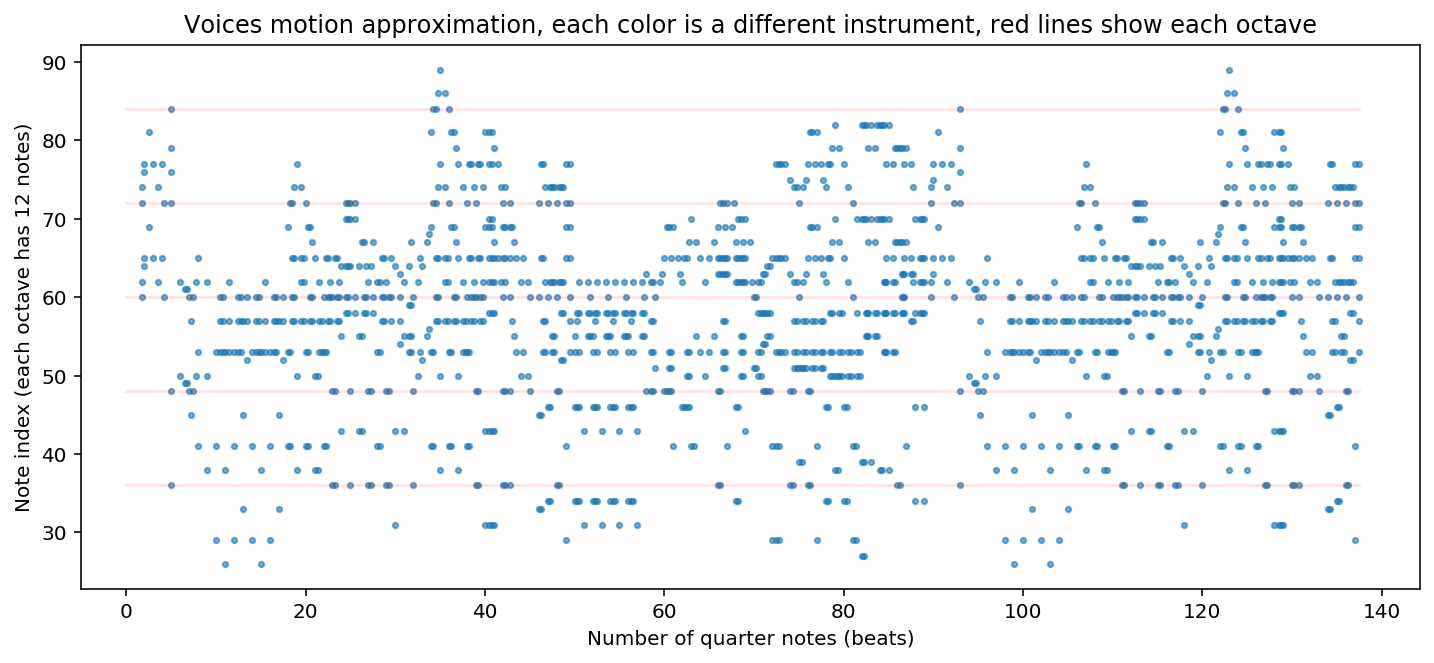

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark andante moderato Quarter=84.0>
    {0.0} <music21.key.Key of F major>
    {0.0} <music21.meter.TimeSignature 2/4>
    {0.0} <music21.note.Rest rest>
    {1.75} <music21.chord.Chord C4 D4 C5 D5>


In [0]:
from music21 import stream

temp_midi_chords = open_midi(
    (file_path+"/"+ "/Le-Piccadilly.mid"),
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")

In [0]:
from music21 import roman

def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

otro_midi = base_midi = open_midi((file_path+'/'+ "Sarabande-No.1.mid"), True)
harmonic_reduction(otro_midi)[0:10]

['i',
 '##vi7',
 '##vi',
 '##vi7',
 '#IV7',
 '#ii6',
 '#i53',
 '#IV53',
 '#IV53',
 '##vi7']

In [0]:
from music21 import corpus

bachChorale = corpus.parse('bach/bwv846')
harmonic_reduction(bachChorale)[0:11]

['I', 'ii42', 'vii53', 'I', 'vi6', 'ii42', 'V6', 'i42', 'vi7', 'II7', 'V']


What we did before is a harmonic reduction. You have to be careful with this because possibly some melody changes some of the chords.


In [0]:
# Cargamos la data de los midis en un array

from music21 import converter, instrument, note, chord
import glob
notes = []
for file in glob.glob("/content/MIDIs/classics/satie/*.mid"):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # si el midi tiene partes
        notes_to_parse = parts.parts[0].recurse()
    else: # el midi tiene notas solamente
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

In [0]:
midi = converter.parse("/content/MIDIs/classics/satie/Ogive-No.3.mid")

In [0]:
midi

<music21.stream.Score 0x7f04e187d0b8>

In [0]:
parts = instrument.partitionByInstrument(midi)

In [0]:
parts[0]

<music21.stream.Part Piano>

In [0]:
notes_to_parse = parts.parts[0].recurse()

In [0]:
notes_to_parse

<music21.stream.iterator.RecursiveIterator for Part:Piano @:0>

In [0]:
# I have this array of chords and notes,
# example 'D3' is a note, '2.5.9' is a chord
notes

['A5',
 'A2',
 'A5',
 'E-5',
 '9.0.4',
 'E-5',
 'F#5',
 'F#5',
 '9.0.4',
 'A2',
 'E5',
 '9.0.4',
 'E5',
 'E-5',
 'E-5',
 'C5',
 '9.0.4',
 'C5',
 'B4',
 'E2',
 'B4',
 '4.7.11',
 '4.7.11',
 'E2',
 '4.7.11',
 '4.7.11',
 'A5',
 'A2',
 'A5',
 'E-5',
 '9.0.4',
 'E-5',
 'F#5',
 'F#5',
 '9.0.4',
 'A2',
 'E5',
 '9.0.4',
 'E5',
 'E-5',
 'E-5',
 'C5',
 '9.0.4',
 'C5',
 'B4',
 'E2',
 'B4',
 '4.7.11',
 '4.7.11',
 'B4',
 'D5',
 'D2',
 'B4',
 '2.5.9',
 'B4',
 'C5',
 'C5',
 '2.5.9',
 'B4',
 'E2',
 'B4',
 '4.8.11',
 '4.8.11',
 'B4',
 'D5',
 'D2',
 '2.5.9',
 '2.5.9',
 'D2',
 'B4',
 '2.5.9',
 'B4',
 'D5',
 'D5',
 'B4',
 '2.5.9',
 'B4',
 'G#4',
 'D2',
 'A4',
 'B4',
 '2.5.9',
 'D5',
 'B4',
 'A4',
 'G#4',
 '2.5.9',
 'A4',
 'B4',
 'D2',
 'D5',
 'B4',
 '2.5.9',
 'A4',
 'G#4',
 'A4',
 'B4',
 '2.5.9',
 'D5',
 'F5',
 'A1',
 'F5',
 'A4',
 '9.0.4',
 'A4',
 '9.0.4',
 'A2',
 '9.0.4',
 '9.0.4',
 'E5',
 'E2',
 'E5',
 'B-4',
 '4.7.11',
 'B-4',
 'C#5',
 'C#5',
 '4.7.11',
 'E2',
 'B4',
 '4.7.11',
 'B4',
 'B-4',
 'B-4',
 

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

In [0]:


n_vocab = len(set(notes))

# vamos a considerar 100 notas/acordes, o sea, para predecir la proxima nota, 
# el modelo tiene en cuenta 100 notas anteriores para hacer la prediccion
sequence_length = 100

# sacamos todos los pitches ordenados
pitchnames = sorted(set(item for item in notes))
# creamos directorio para mapear pitchs a enteros
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)

In [0]:
network_input

array([[[0.69506726],
        [0.68161435],
        [0.69506726],
        ...,
        [0.26457399],
        [0.8206278 ],
        [0.93721973]],

       [[0.68161435],
        [0.69506726],
        [0.85201794],
        ...,
        [0.8206278 ],
        [0.93721973],
        [0.67713004]],

       [[0.69506726],
        [0.85201794],
        [0.64573991],
        ...,
        [0.93721973],
        [0.67713004],
        [0.93721973]],

       ...,

       [[0.92825112],
        [0.68609865],
        [0.8161435 ],
        ...,
        [0.9058296 ],
        [0.76681614],
        [0.71748879]],

       [[0.68609865],
        [0.8161435 ],
        [0.93273543],
        ...,
        [0.76681614],
        [0.71748879],
        [0.90134529]],

       [[0.8161435 ],
        [0.93273543],
        [0.8161435 ],
        ...,
        [0.71748879],
        [0.90134529],
        [0.76233184]]])

In [0]:
n_vocab

223

In [0]:
note_to_int

{'0': 0,
 '0.1.5.6': 1,
 '0.1.5.8': 2,
 '0.2': 3,
 '0.2.4': 4,
 '0.2.6': 5,
 '0.3': 6,
 '0.3.6': 7,
 '0.3.7': 8,
 '0.4': 9,
 '0.4.6': 10,
 '0.4.7': 11,
 '0.4.8': 12,
 '0.5': 13,
 '0.6': 14,
 '1': 15,
 '1.2': 16,
 '1.3': 17,
 '1.4': 18,
 '1.4.6': 19,
 '1.4.7': 20,
 '1.4.8': 21,
 '1.5': 22,
 '1.5.6': 23,
 '1.5.8': 24,
 '1.5.9': 25,
 '1.6': 26,
 '1.7': 27,
 '10': 28,
 '10.0': 29,
 '10.0.3': 30,
 '10.0.3.5': 31,
 '10.1': 32,
 '10.1.3': 33,
 '10.1.4': 34,
 '10.1.5': 35,
 '10.11.3.4': 36,
 '10.2': 37,
 '10.2.5': 38,
 '10.3': 39,
 '11': 40,
 '11.0': 41,
 '11.0.5': 42,
 '11.1': 43,
 '11.2': 44,
 '11.2.6': 45,
 '11.3': 46,
 '11.3.4': 47,
 '11.3.5': 48,
 '11.3.6': 49,
 '11.4': 50,
 '2': 51,
 '2.3.7.10': 52,
 '2.3.7.8': 53,
 '2.4': 54,
 '2.4.8': 55,
 '2.5': 56,
 '2.5.7': 57,
 '2.5.8': 58,
 '2.5.9': 59,
 '2.6': 60,
 '2.6.10': 61,
 '2.6.8': 62,
 '2.6.9': 63,
 '2.7': 64,
 '2.8': 65,
 '3': 66,
 '3.4': 67,
 '3.5': 68,
 '3.5.9': 69,
 '3.6': 70,
 '3.6.10': 71,
 '3.7': 72,
 '3.7.10': 73,
 '3.7.11': 74,
 

In [0]:
model = Sequential()
model.add(LSTM(
        256,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=1, batch_size=64, callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





9428/9428 [==============================] - 88s 9ms/step - loss: 4.7645


In [0]:
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []


# generamos 500 notas
for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern = np.append(pattern,index)
    pattern = pattern[1:len(pattern)]



In [0]:
pattern

NameError: ignored

In [0]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [0]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'